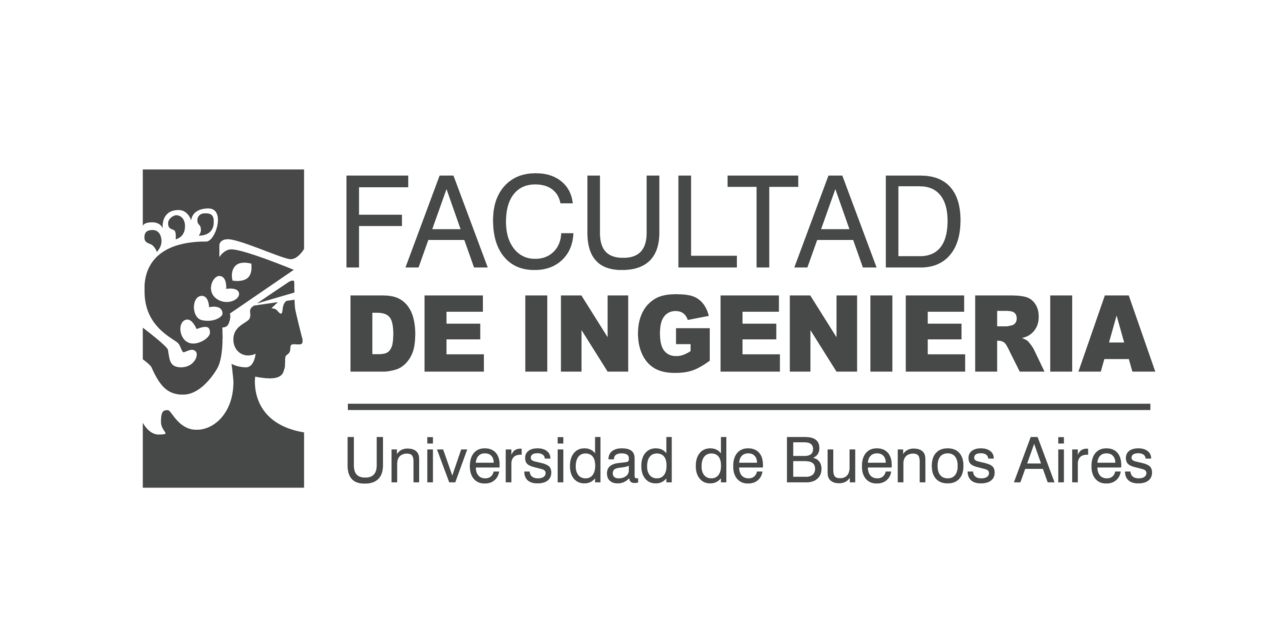

**Desafío 3:** <br />
Modelo de lenguaje con tokenización por caracteres

**Profesores:** <br />
Dr. Rodrigo Cardenas Szigety - rodrigo.cardenas.sz@gmail.com <br />
Dr. Nicolás Vattuone - nicolas.vattuone@gmail.com <br />

**Alumno:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-nlp - Ver desafios/Desafio_3.ipynb<br />


### Consigna y Sugerencias

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


#### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

#### Aclaración
Por comentarios sobre la posibilidad de utilziar PyTorch, por experiencia previa con esta libreria y por que no he podido utilizar mis recursos de GPU con Keras es que este trabajo será realizado con PyTorch.

### Requerimientos y utilidades

In [33]:
%pip install torch
%pip install plotly
%pip install wordcloud
%pip install nltk
%pip install matplotlib pandas seaborn numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [84]:
import re
import time
import json
import nltk
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


# Descargar las stopwords en caso de que no estén disponibles
nltk.download('stopwords')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset y Tokenización

Utilizaremos como dataset el corpus que contiene la biblia la odisea y la eneida.

In [2]:
# Se utiliza el mismo dataset que se usó en la notebook del desafío 2.
df = pd.read_csv('corpus.txt', sep='/n', header=None)
print("Cantidad de documentos:", df.shape[0])

/tmp/ipykernel_10296/3448344077.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('corpus.txt', sep='/n', header=None)


Cantidad de documentos: 58220


Se implementan funciones para remover caracteres especiales y se remueven palabras con acentos para reducir la complejidad de los carácteres a predecir por el modelo.

In [3]:
def remove_special_characters(text: str) -> str:
    """
    Elimina caracteres especiales y acentos de un texto.

    Args:
        text (str): Texto a limpiar.

    Returns:
        str: Texto limpio.
    """
    reemplazos = {
        r'[áÁ]': 'a',
        r'[éÉ]': 'e',
        r'[íÍ]': 'i',
        r'[óÓ]': 'o',
        r'[úÚ]': 'u',
        r'[ñÑ]': 'n'
    }
    for pattern, replace in reemplazos.items():
        text = re.sub(pattern, replace, text)
    return text

def clean_corpus(df: pd.DataFrame, text_column: str = "texto") -> pd.DataFrame:
    def clean_text(text: str) -> str:
        text = text.lower()
        text = remove_special_characters(text)
        # Dejar solo caracteres en español, números y signos de puntuación comunes
        # Eliminar letras griegas y otros símbolos no deseados
        text = re.sub(r"[^a-zñáéíóúü0-9\s\.,;:¡!¿?\-_'\"\(\)\[\]\{\}]", "", text)
        text = re.sub(r'\s+', ' ', text)  # quitar múltiples espacios
        return text

    df[text_column] = df[text_column].apply(clean_text)
    return df

def word_cloud(df: pd.DataFrame) -> WordCloud:
    """
    Genera un wordcloud a partir de un dataframe.

    Args:
        df (pd.DataFrame): Dataframe que contiene el texto para el wordcloud.

    Returns:
        WordCloud: Instancia de WordCloud generada a partir del texto.
    """
    # Combinar todo el texto del dataframe en una sola cadena
    text = " ".join(df[0].astype(str).tolist())

    # Crear el wordcloud
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)
    
    return wordcloud

df_clean = clean_corpus(df, text_column=0)
print("Cantidad de documentos luego de limpiar:", df_clean.shape[0])
print(df_clean.iloc[500:521].head(40))


Cantidad de documentos luego de limpiar: 58220
                                                     0
500  de un varon cuyos blancos huesos se pudren en ...
501  accion de la lluvia o los revuelven las olas e...
502  le vieran aportar a itaca, preferirian tener l...
503  ricos de oro y de vestidos. mas aquel ya murio...
504  destino, y no hay que esperar en su tornada, a...
505  hombres terrestres afirme que aun ha de volver...
506  no amanecera jamas. pero, ea, habla y responde...
507  eres y de que pais procedes? ¿donde se hallan ...
508  ¿en cual embarcacion llegaste? ¿como los marin...
509  itaca? ¿quienes se precian de ser? pues no me ...
510  andando. dime tambien la verdad de esto para q...
511  ahora por vez primera o has sido huesped de mi...
512  los que conocen nuestra casa, porque ulises ac...
513                                 los demas hombres.
514  178 respondiole minerva, la deidad de los bril...
515  esto voy a informarte circunstanciadamente. me...
516  hijo del beli

Se vuelva el corpus de dataset a un string para luego poder ser tokenizado y armar el vocabulario.

In [4]:
article_text = " ".join(df_clean[0].astype(str).tolist())

In [5]:
article_text[50000:51000]  # Mostrar los primeros 1000 caracteres del texto limpio

' momento fatal de la aterradora muerte. ¡no se me vaya a indignar alguna de las aqueas del pueblo, si ve enterrar sin mortaja a un hombre que ha poseido tantos bienes!_ asi dijo, y nuestro animo generoso se dejo persuadir. desde aquel instante pasaba el dia labrando la gran tela, y por la noche, tan luego como se alumbraba con las antorchas, deshacia lo tejido. de esta suerte logro ocultar el engano y que sus palabras fueran creidas por los aqueos durante un trienio; mas, asi que vino el cuarto ano y volvieron a sucederse las estaciones, nos lo revelo una de las mujeres, que conocia muy bien lo que pasaba, y sorprendimos a penelope destejiendo la esplendida tela. asi fue como, mal de su grado, se vio en la necesidad de acabarla. oye, pues, lo que te responden los pretendientes, para que lo sepa tu espiritu y lo sepan tambien los aqueos todos. haz que tu madre vuelva a su casa, y ordenale que tome por esposo a quien su padre le aconseje y a ella le plazca. y si atormentare largo tiempo

In [6]:
max_context_size = 100 # seleccionamos el tamaño de contexto a ojo en una primera instancia
chars_vocab = set(article_text)
chars_vocab_size = len(chars_vocab)
print("Tamaño del corpus:", len(article_text))
print("Cantidad de caracteres únicos en el vocabulario:", chars_vocab_size)
# Mostramos los primeros 100 caracteres del vocabulario ordenados: primero números, luego letras, luego el resto
chars_vocab_sorted = sorted(chars_vocab, key=lambda x: (not x.isdigit(), not x.isalpha(), x))
print("Primeros 100 caracteres del vocabulario ordenados (números, letras, otros):", chars_vocab_sorted[:100])

Tamaño del corpus: 5191816
Cantidad de caracteres únicos en el vocabulario: 53
Primeros 100 caracteres del vocabulario ordenados (números, letras, otros): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ü', ' ', '!', '"', '(', ')', ',', '-', '.', ':', ';', '?', '[', ']', '_', '¡', '¿']


In [7]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [25]:
def save_vocab_to_file(char2idx: dict, idx2char: dict, filename: str):
    """
    Guarda los diccionarios de vocabulario a un archivo JSON.

    Args:
        char2idx (dict): Diccionario que asigna caracteres a índices.
        idx2char (dict): Diccionario que asigna índices a caracteres.
        filename (str): Nombre del archivo donde se guardarán los diccionarios.
    """
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump({'char2idx': char2idx, 'idx2char': idx2char}, f, ensure_ascii=False)
        
def load_vocab_from_file(filename: str) -> tuple:
    """
    Carga los diccionarios de vocabulario desde un archivo JSON.

    Args:
        filename (str): Nombre del archivo desde donde se cargarán los diccionarios.

    Returns:
        tuple: Dos diccionarios, `char2idx` e `idx2char`.
    """
    with open(filename, 'r', encoding='utf-8') as f:
        vocab = json.load(f)
    return vocab['char2idx'], vocab['idx2char']

In [24]:
save_vocab_to_file(char2idx, idx2char, 'vocab.json')

Se guarda el vocabulario en *vocab.json* para poder ser utilizado en etapas posteriores sin tener que regenerarlo.

####  Tokenizar

In [8]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [10]:
for i in range(0, 200, 20):
    print(tokenized_text[i:i+20])

[26, 3, 15, 21, 9, 19, 5, 45, 15, 34, 26, 21, 44, 40, 26, 15, 22, 0, 15, 19]
[44, 21, 15, 0, 5, 5, 28, 21, 5, 51, 21, 16, 4, 21, 5, 37, 38, 13, 15, 4]
[21, 26, 3, 38, 13, 21, 15, 0, 5, 5, 28, 21, 38, 13, 21, 51, 5, 19, 21, 26]
[3, 15, 21, 40, 13, 15, 21, 5, 51, 21, 4, 22, 20, 5, 22, 15, 21, 4, 22, 20]
[41, 3, 15, 19, 15, 21, 38, 22, 21, 26, 3, 15, 21, 40, 22, 38, 26, 15, 37, 21]
[13, 26, 4, 26, 15, 13, 21, 4, 22, 37, 21, 39, 5, 13, 26, 21, 5, 26, 3, 15]
[19, 21, 9, 4, 19, 26, 13, 21, 5, 51, 21, 26, 3, 15, 21, 41, 5, 19, 16, 37]
[21, 4, 26, 21, 22, 5, 21, 34, 5, 13, 26, 21, 4, 22, 37, 21, 41, 38, 26, 3]
[21, 4, 16, 39, 5, 13, 26, 21, 22, 5, 21, 19, 15, 13, 26, 19, 38, 34, 26, 38]
[5, 22, 13, 21, 41, 3, 4, 26, 13, 5, 15, 49, 15, 19, 6, 21, 20, 5, 40, 21]


#### Organizando y estructurando el dataset

In [11]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.15
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [12]:
len(train_text)/len(tokenized_text), len(val_text)/len(tokenized_text)

(0.8499946839410334, 0.15000531605896664)

Se separa el dataset en *train* y *validation* y se estructura el problema de aprendizaje como *many-to-many*:

- **Entrada**: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

- **Target**: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [18]:
print(train_text[:20])
print(val_text[:20])

[26, 3, 15, 21, 9, 19, 5, 45, 15, 34, 26, 21, 44, 40, 26, 15, 22, 0, 15, 19]
[4, 21, 16, 5, 13, 21, 13, 4, 34, 15, 19, 37, 5, 26, 15, 13, 12, 21, 20, 21]


In [ ]:
class CharDataset(Dataset):
    def __init__(self, encoded_text, context_size):
        self.context_size = context_size
        self.encoded = encoded_text

    def __len__(self):
        return len(self.encoded) - self.context_size

    def __getitem__(self, idx):
        x = torch.tensor(self.encoded[idx:idx + self.context_size])
        y = torch.tensor(self.encoded[idx + 1:idx + self.context_size + 1]) # target desplazado un carácter
        return x, y


In [20]:
train_dataset = CharDataset(train_text, context_size=max_context_size)
val_dataset = CharDataset(val_text, context_size=max_context_size)

#### Generación de texto (Greedy, Sampling, Beam)

In [76]:
def greedy_generation(model, input_tensor, idx2char, max_len, device):
    generated = input_tensor.clone()
    for _ in range(max_len):
        with torch.no_grad():
            output = model(generated)
            next_char_logits = output[:, -1, :]
            next_char = torch.argmax(next_char_logits, dim=-1).unsqueeze(0)
            generated = torch.cat((generated, next_char), dim=1)
    return ''.join([idx2char[int(i)] for i in generated[0]])

def sampling_generation(model, input_tensor, idx2char, max_len, temperature, device):
    generated = input_tensor.clone()
    for _ in range(max_len):
        with torch.no_grad():
            output = model(generated)
            logits = output[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_char = torch.multinomial(probs, num_samples=1)
            generated = torch.cat((generated, next_char), dim=1)
    return ''.join([idx2char[int(i)] for i in generated[0]])

def beam_search(model, input_tensor, idx2char, char2idx, max_len, beam_width, device):
    sequences = [(input_tensor, 0.0)]  # (tensor, score)

    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            with torch.no_grad():
                output = model(seq)
                logits = output[:, -1, :]
                log_probs = F.log_softmax(logits, dim=-1)
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)

                for i in range(beam_width):
                    next_char = topk_indices[0, i].unsqueeze(0).unsqueeze(0)
                    new_seq = torch.cat((seq, next_char), dim=1)
                    new_score = score + topk_log_probs[0, i].item()
                    all_candidates.append((new_seq, new_score))

        # Seleccionamos los `beam_width` mejores candidatos
        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    # Devolvemos la secuencia con mayor score
    best_sequence = sequences[0][0]
    return ''.join([idx2char[int(i)] for i in best_sequence[0]])

def stochastic_beam_search(model, input_tensor, idx2char, char2idx, max_len, beam_width, device, temperature=1.0):
    model.eval()
    sequences = [(input_tensor, 0.0)]  # (tensor, cumulative_log_prob)

    for _ in range(max_len):
        all_candidates = []

        for seq, score in sequences:
            with torch.no_grad():
                output = model(seq)
                logits = output[:, -1, :] / temperature
                log_probs = F.log_softmax(logits, dim=-1)

                # Convert log_probs to probs for sampling
                probs = torch.exp(log_probs).squeeze()
                
                # Amostramos `beam_width` índices proporcional a probs
                sampled_indices = torch.multinomial(probs, num_samples=beam_width, replacement=False)

                for idx in sampled_indices:
                    next_char = idx.unsqueeze(0).unsqueeze(0).to(device)
                    new_seq = torch.cat((seq, next_char), dim=1)
                    new_score = score + log_probs[0, idx].item()
                    all_candidates.append((new_seq, new_score))

        # Seleccionamos los `beam_width` candidatos con mayor score acumulado
        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    # Devolvemos la mejor secuencia generada
    best_seq = sequences[0][0]
    return ''.join([idx2char[int(i)] for i in best_seq[0]])

def generate_text(model, start_text, char2idx, idx2char, device, generation_mode="greedy", max_len=300, temperature=1.0, beam_width=3):
    model.eval()
    input_ids = [char2idx[c] for c in start_text]
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)

    if generation_mode == "greedy":
        return greedy_generation(model, input_tensor, idx2char, max_len, device)

    elif generation_mode == "sampling":
        return sampling_generation(model, input_tensor, idx2char, max_len, temperature, device)

    elif generation_mode == "beam":
        return beam_search(model, input_tensor, idx2char, char2idx, max_len, beam_width, device)
    elif generation_mode == "stochastic_beam":
        return stochastic_beam_search(model, input_tensor, idx2char, char2idx, max_len, beam_width, device, temperature)

    else:
        raise ValueError(f"Unknown generation mode: {generation_mode}")


### Modelos

In [98]:
class CharRNN(nn.Module):
    """
    Modelo de red neuronal recurrente para generación de texto carácter por carácter.

    Este modelo utiliza una capa de embedding, seguida de una capa recurrente (RNN, GRU o LSTM)
    y una capa lineal que genera los logits de salida para cada paso de la secuencia.

    Args:
        vocab_size (int): Tamaño del vocabulario (cantidad de caracteres únicos).
        embedding_dim (int): Dimensión de los vectores de embedding.
        hidden_dim (int): Tamaño de la capa oculta de la RNN.
        rnn_type (str): Tipo de RNN a utilizar: 'rnn', 'gru' o 'lstm'.
        num_layers (int): Número de capas recurrentes apiladas.

    Nota:
        Este modelo está diseñado para tareas de modelado de lenguaje a nivel carácter,
        donde se predice el próximo carácter dado un contexto anterior.
        
        La activación softmax no se aplica explícitamente en la capa de salida,
        ya que:
        - Durante el entrenamiento, se usa CrossEntropyLoss que aplica log-softmax internamente.
        - Durante la generación, se aplica softmax o sampling según la estrategia elegida (greedy, temperatura, beam search).
"""
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, rnn_type='rnn', num_layers=1, dropout=0.0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("rnn_type must be one of: 'rnn', 'gru', 'lstm'")

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)  # (batch, seq_len, embedding_dim)
        out, _ = self.rnn(x)
        out = self.dropout(out) # Aplicamos dropout después de la RNN
        logits = self.fc(out)  # (batch, seq_len, vocab_size)
        return logits


#### Entrenamiento

In [99]:
def evaluate_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    count = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), reduction='sum')
            total_loss += loss.item()
            count += y.numel()

    avg_loss = total_loss / count
    return math.exp(avg_loss)  # Perplejidad

def train(
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        device, 
        max_epochs=50, 
        patience=5, 
        name="char_rnn", 
        history_path="train_history.json"
    ):
    best_ppl = float('inf')
    patience_counter = 0
    history = {
        "name": name,
        "train_ppl": [],
        "val_ppl": [],
        "train_time_seconds": None
    }
    
    start_time = time.time() 

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_ppl = math.exp(avg_loss)
        val_ppl = evaluate_perplexity(model, val_loader, device)

        history["train_ppl"].append(train_ppl)
        history["val_ppl"].append(val_ppl)

        print(f"Epoca {epoch}: train_ppl = {train_ppl:.4f}, val_ppl = {val_ppl:.4f}")

        if val_ppl < best_ppl:
            best_ppl = val_ppl
            patience_counter = 0
            torch.save(model.state_dict(), f"{name}_model.pt")
            print(f"Guardando nuevo mejor modelo en epoca {epoch}!")
        else:
            patience_counter += 1
            print(f"No hay mejoras ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("Entrenamiento terminado por Early stopping.")
            break
        
    total_time = time.time() - start_time  # Tiempo final
    history["train_time_seconds"] = round(total_time, 2)
    print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

    # Guardar historial de perplejidades
    with open(history_path, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)
    print(f"Historial guardado en {history_path}")

In [101]:
# Cargar vocab
with open("vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)
char2idx = vocab["char2idx"]
idx2char = vocab["idx2char"]

# Dataloader
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=False)

dropout = 0.1

# Modelo
model_SimpleRNN = CharRNN(
    vocab_size=len(char2idx),
    embedding_dim=64,
    hidden_dim=200,
    rnn_type="rnn",
    dropout=dropout
).to(device)

model_SimpleLSTM = CharRNN(
    vocab_size=len(char2idx),
    embedding_dim=64,
    hidden_dim=200,
    rnn_type="lstm",
    dropout=dropout    
).to(device)

model_SimpleGRU = CharRNN(
    vocab_size=len(char2idx),
    embedding_dim=64,
    hidden_dim=200,
    rnn_type="gru",
    dropout=dropout
).to(device)

optimizer_rnn = torch.optim.RMSprop(model_SimpleRNN.parameters(), lr=0.001)
optimizer_lstm = torch.optim.RMSprop(model_SimpleLSTM.parameters(), lr=0.001)
optimizer_gru = torch.optim.RMSprop(model_SimpleGRU.parameters(), lr=0.001)

In [103]:
# Entrenamiento del modelo SimpleRNN
train(
    model=model_SimpleRNN,
    train_loader=train_dl,
    val_loader=val_dl,
    optimizer=optimizer_rnn,
    device=device,
    max_epochs=50,
    patience=5,
    name="char_rnn_droput",  # Nombre del modelo para guardar
    history_path="char_rnn_2layer_history.json"
)

Epoca 1: train_ppl = 4.3228, val_ppl = 4.0371
Guardando nuevo mejor modelo en epoca 1!
Epoca 2: train_ppl = 4.2208, val_ppl = 4.0211
Guardando nuevo mejor modelo en epoca 2!
Epoca 3: train_ppl = 4.2104, val_ppl = 4.0191
Guardando nuevo mejor modelo en epoca 3!
Epoca 4: train_ppl = 4.2084, val_ppl = 4.0129
Guardando nuevo mejor modelo en epoca 4!
Epoca 5: train_ppl = 4.2101, val_ppl = 4.0145
No hay mejoras (1/5)
Epoca 6: train_ppl = 4.2126, val_ppl = 4.0195
No hay mejoras (2/5)
Epoca 7: train_ppl = 4.2219, val_ppl = 4.0323
No hay mejoras (3/5)
Epoca 8: train_ppl = 4.2252, val_ppl = 4.0196
No hay mejoras (4/5)
Epoca 9: train_ppl = 4.2310, val_ppl = 4.0133
No hay mejoras (5/5)
Entrenamiento terminado por Early stopping.
Tiempo total de entrenamiento: 3799.27 segundos
Historial guardado en char_rnn_2layer_history.json


In [104]:
# Entrenamiento del modelo SimpleRNN
train(
    model=model_SimpleLSTM,
    train_loader=train_dl,
    val_loader=val_dl,
    optimizer=optimizer_lstm,
    device=device,
    max_epochs=50,
    patience=5,
    name="char_lstm",  # Nombre del modelo para guardar
    history_path="char_lstm_2layer_history.json"
)

Epoca 1: train_ppl = 3.5780, val_ppl = 3.5336
Guardando nuevo mejor modelo en epoca 1!
Epoca 2: train_ppl = 3.3588, val_ppl = 3.5256
Guardando nuevo mejor modelo en epoca 2!
Epoca 3: train_ppl = 3.3294, val_ppl = 3.5140
Guardando nuevo mejor modelo en epoca 3!
Epoca 4: train_ppl = 3.3152, val_ppl = 3.5215
No hay mejoras (1/5)
Epoca 5: train_ppl = 3.3062, val_ppl = 3.5238
No hay mejoras (2/5)
Epoca 6: train_ppl = 3.2997, val_ppl = 3.5140
No hay mejoras (3/5)
Epoca 7: train_ppl = 3.2948, val_ppl = 3.5126
Guardando nuevo mejor modelo en epoca 7!
Epoca 8: train_ppl = 3.2911, val_ppl = 3.5154
No hay mejoras (1/5)
Epoca 9: train_ppl = 3.2881, val_ppl = 3.5139
No hay mejoras (2/5)
Epoca 10: train_ppl = 3.2856, val_ppl = 3.5150
No hay mejoras (3/5)
Epoca 11: train_ppl = 3.2834, val_ppl = 3.5103
Guardando nuevo mejor modelo en epoca 11!
Epoca 12: train_ppl = 3.2814, val_ppl = 3.5167
No hay mejoras (1/5)
Epoca 13: train_ppl = 3.2798, val_ppl = 3.5119
No hay mejoras (2/5)
Epoca 14: train_ppl = 3.

In [105]:
# Entrenamiento del modelo SimpleRNN
train(
    model=model_SimpleGRU,
    train_loader=train_dl,
    val_loader=val_dl,
    optimizer=optimizer_gru,
    device=device,
    max_epochs=50,
    patience=5,
    name="char_gru",  # Nombre del modelo para guardar
    history_path="char_gru_2layer_history.json"
)

Epoca 1: train_ppl = 3.7395, val_ppl = 3.6420
Guardando nuevo mejor modelo en epoca 1!
Epoca 2: train_ppl = 3.5816, val_ppl = 3.6196
Guardando nuevo mejor modelo en epoca 2!
Epoca 3: train_ppl = 3.5573, val_ppl = 3.6235
No hay mejoras (1/5)
Epoca 4: train_ppl = 3.5449, val_ppl = 3.6125
Guardando nuevo mejor modelo en epoca 4!
Epoca 5: train_ppl = 3.5355, val_ppl = 3.6117
Guardando nuevo mejor modelo en epoca 5!
Epoca 6: train_ppl = 3.5296, val_ppl = 3.5928
Guardando nuevo mejor modelo en epoca 6!
Epoca 7: train_ppl = 3.5248, val_ppl = 3.6066
No hay mejoras (1/5)
Epoca 8: train_ppl = 3.5204, val_ppl = 3.5951
No hay mejoras (2/5)
Epoca 9: train_ppl = 3.5178, val_ppl = 3.6016
No hay mejoras (3/5)
Epoca 10: train_ppl = 3.5155, val_ppl = 3.5929
No hay mejoras (4/5)
Epoca 11: train_ppl = 3.5132, val_ppl = 3.7062
No hay mejoras (5/5)
Entrenamiento terminado por Early stopping.
Tiempo total de entrenamiento: 8936.56 segundos
Historial guardado en char_gru_2layer_history.json


In [49]:
def plot_train_histories(history_files):
    """
    Dibuja curvas de perplejidad para múltiples archivos de historial de entrenamiento.
    
    Args:
        history_files (list of str): Lista de rutas a archivos .json
    """
    plt.figure(figsize=(10, 6))

    for file_path in history_files:
        with open(file_path, "r", encoding="utf-8") as f:
            history = json.load(f)

        name = history.get("name", file_path)
        train_ppl = history["train_ppl"]
        val_ppl = history["val_ppl"]
        epochs = range(1, len(train_ppl) + 1)

        plt.plot(epochs, train_ppl, label=f"{name} (train)", linestyle="--")
        plt.plot(epochs, val_ppl, label=f"{name} (val)", linewidth=2)

    plt.xlabel("Época")
    plt.ylabel("Perplejidad")
    plt.title("Evolución de la perplejidad por modelo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

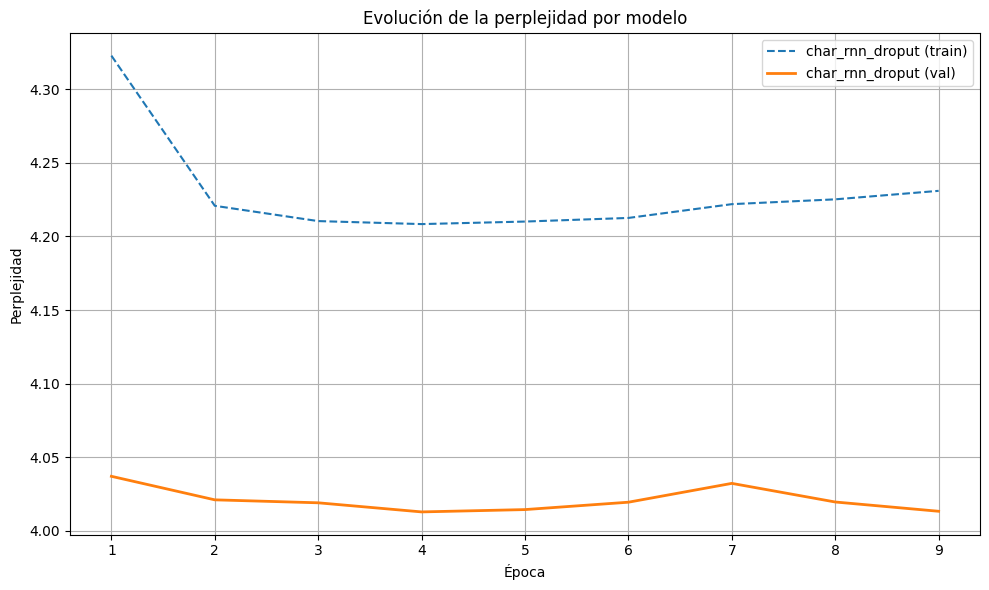

In [106]:
plot_train_histories([
    "char_rnn_2layer_history.json",
    # "char_lstm_2layer_history.json",
    # "char_gru_2layer_history.json",
])

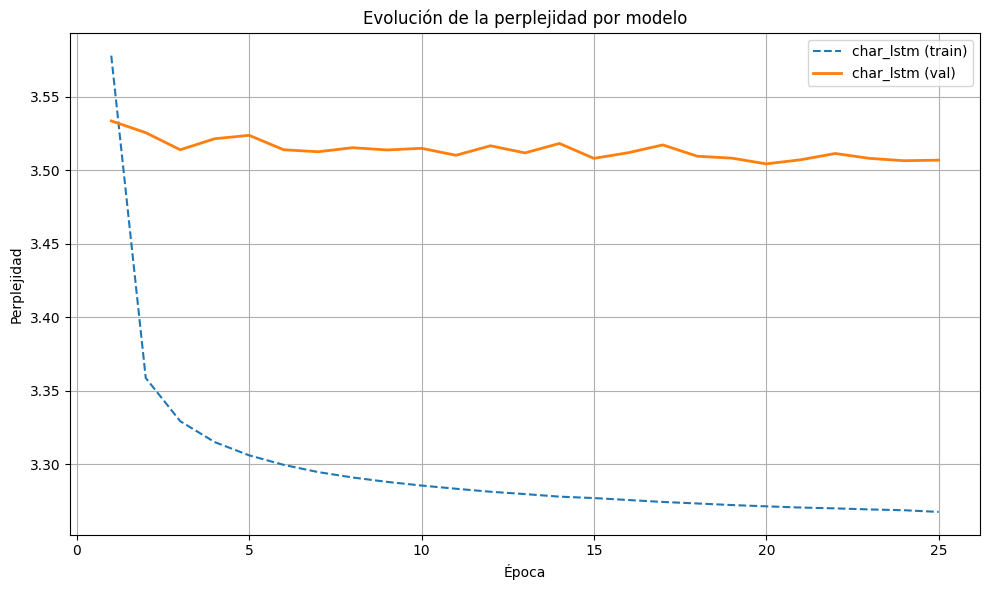

In [107]:
plot_train_histories([
    # "char_rnn_2layer_history.json",
    "char_lstm_2layer_history.json",
    # "char_gru_2layer_history.json",
])

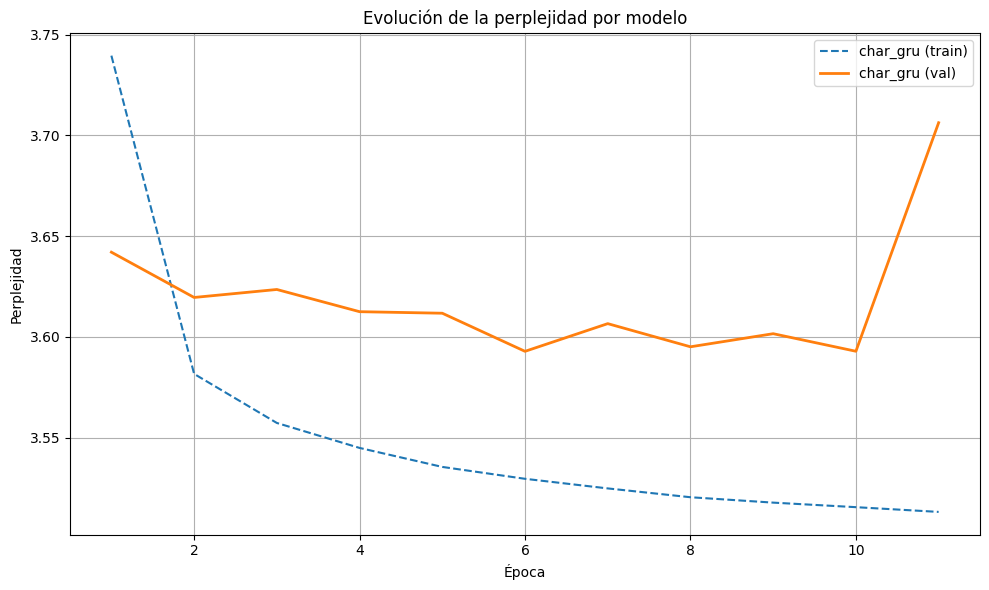

In [108]:
plot_train_histories([
    # "char_rnn_2layer_history.json",
    # "char_lstm_2layer_history.json",
    "char_gru_2layer_history.json",
])

In [ ]:
# Cargar vocab
with open("vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)
char2idx = vocab["char2idx"]
idx2char = {int(k): v for k, v in vocab["idx2char"].items()} 

# Cargar modelos desde archivos .pt
# model_SimpleRNN.load_state_dict(torch.load("char_rnn_model.pt", map_location=device))
# model_SimpleRNN.load_state_dict(torch.load("char_rnn_dropout_model.pt", map_location=device))
# model_SimpleLSTM.load_state_dict(torch.load("char_lstm_model.pt", map_location=device))
# model_SimpleGRU.load_state_dict(torch.load("char_gru_model.pt", map_location=device))

models = {
    "SimpleRNN": model_SimpleRNN,
    "SimpleLSTM": model_SimpleLSTM,
    "SimpleGRU": model_SimpleGRU,
}

max_len=100
temperatures = [0.5, 0.7, 1.0]
beams = [3, 5, 7]

for name, model in models.items():
    beam_results = []
    sampling_results = []
    beam_sto_results = []
    
    print(50*"=")
    print(f"Generando texto con el modelo {name}...")
    greedy = generate_text(
        model, 
        start_text="no resistais al", 
        char2idx=char2idx, 
        idx2char=idx2char, 
        device=device, 
        generation_mode="greedy", 
        max_len=max_len
    )

    for temp in temperatures:
        sampling_results.append(generate_text(
            model, 
            start_text="no resistais al", 
            char2idx=char2idx, 
            idx2char=idx2char, 
            device=device, 
            generation_mode="sampling", 
            max_len=max_len,
            temperature=temp
        ))
           
    for beam_width in beams:
        beam_results.append(generate_text(
            model, 
            start_text="no resistais al", 
            char2idx=char2idx, 
            idx2char=idx2char, 
            device=device, 
            generation_mode="beam", 
            max_len=max_len,
            beam_width=beam_width,
            temperature=temp
        ))
        
    for beam_width in beams:
        for temp in temperatures:
            beam_sto_results.append(generate_text(
                model, 
                start_text="no resistais al", 
                char2idx=char2idx, 
                idx2char=idx2char, 
                device=device, 
                generation_mode="stochastic_beam", 
                max_len=max_len,
                beam_width=beam_width,
                temperature=temp
            ))

    print("Generación con Greedy:")
    print(greedy)
    print("\nGeneración con Sampling:")
    for i, sampling in enumerate(sampling_results):
        print(f"Temperatura {temperatures[i]}: {sampling}")
    print("\nGeneración con Beam Search:")
    for i, beam in enumerate(beam_results):
        print(f"Beam Width {beams[i % len(beams)]}: {beam}")
    print("\nGeneración con Beam Search Estocastico:")
    for i, beam in enumerate(beam_sto_results):
        print(f"Beam Width {beams[i % len(beams)]} con temperatura {temperatures[i // len(beams) % len(temperatures)]}: {beam}")

Generando texto con el modelo SimpleRNN...
Generación con Greedy:
no resistais al palacio de la casa de jehova de los ejercitos de la casa de jehova de los ejercitos de la casa de jehova de los ejercitos de la casa de jehova de los ejercitos de la casa de jehova de los ejercitos d

Generación con Sampling:
Temperatura 0.5: no resistais al rey de israel, y te entregaran en el partico que no se dijo: no en la casa de los mandamientos, y el dios de israel, diciendo: y este me dijo el hombre que esta asi de la tierra de las cosas que esta
Temperatura 0.7: no resistais al cielo de la plantad en la manara, y el rey por un enemiga en tierra, que la cara la sala el rey pareciendo lo hombres, fueron alcis sanga un conocio de la tierra. y cuatro meno de ella se ha dicho el
Temperatura 1.0: no resistais al insparan los hijos de sidea puesta los hijos de haceria de esto esias? y en el panamente qeiti se libranas fuesen en esclave que quiera que tenia nuevase el el en ensenado: que mi? ¿quien el pr

### Conclusiones